In [1]:
import numpy as np
from env.dis_one_joint import ArmEnv
from utils.util import ReplayMemory as ExpertMemory
from utils.DQN import ReplayMemory, DQN, DQN_Agent
import torch
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [12]:
EP_LEN = 500
expert_len = 50  # number of demonstration
env = ArmEnv(ep_len=EP_LEN)
obs_dim = env.observation_space
action_dim = env.action_dim
seed = 112

# load replay buffer -- state, action, reward, next_state, done
expert_buffer = ExpertMemory(seed=seed, capacity=expert_len*EP_LEN)
expert_buffer.load_buffer(f"../checkpoints/buffer_one_joint_{EP_LEN}_")
print("The length of trajectory %d" %(len(expert_buffer.start_idx)-1))
print("The length of steps %d" %(len(expert_buffer)))

Loading buffer from ../checkpoints/buffer_one_joint_500_
The length of trajectory 500
The length of steps 8057


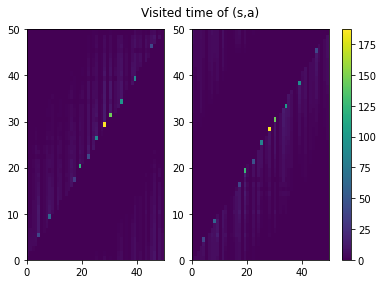

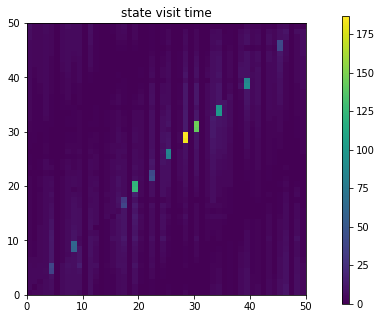

In [15]:
visit_time = np.zeros((obs_dim + [action_dim]))
len_traj = len(expert_buffer.buffer)

for i in range(len_traj):
    state = expert_buffer.buffer[i][0]
    action = expert_buffer.buffer[i][1]
    visit_time[state[0], state[1], action] +=1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Visited time of (s,a)')
im1 = ax1.pcolormesh(visit_time[:, :, 0])
im2 = ax2.pcolormesh(visit_time[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

fig = plt.figure(figsize=(5, 5))
plt.title('state visit time')
s_visit_time = visit_time.sum(axis=2)
plt.pcolormesh(s_visit_time)
cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

In [14]:
for traj_num in range(5):
    init_index = expert_buffer.start_idx[traj_num]
    init_state = expert_buffer.buffer[init_index+1][0]
    env.reset(init_state)
    env.render()

    while init_index < expert_buffer.start_idx[traj_num+1]:
        action = expert_buffer.buffer[init_index][1]
        env.step(action)
        env.render()
        init_index += 1

KeyboardInterrupt: 

In [16]:
env = ArmEnv(ep_len=EP_LEN, scale=True)
obs_dim = env.observation_space
action_dim = env.action_dim
print("len obs_dim: %d" %len(obs_dim), "action_dim: %d" %action_dim)

memory = ReplayMemory(int(1e4))

len obs_dim: 2 action_dim: 2


In [17]:
for steps in range(len(expert_buffer)):
    state = expert_buffer.buffer[steps][0]/env.space_length
    action = expert_buffer.buffer[steps][1]
    reward = expert_buffer.buffer[steps][2]
    next_state = expert_buffer.buffer[steps][3]/env.space_length

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = torch.tensor([action], dtype=torch.int64, device=device).unsqueeze(0)
    reward = torch.tensor([reward], dtype=torch.float32, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    memory.push(state, action, next_state, reward)

In [18]:
BATCH_SIZE = len(memory)
GAMMA = 0.9
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-2
Hidden_size = 64

Q_net = DQN(len(obs_dim), action_dim, Hidden_size).to(device)
Q_target_net = DQN(len(obs_dim), action_dim, Hidden_size).to(device)

Agent = DQN_Agent(env=env, buffer=memory, Q_net=Q_net, Q_target_net=Q_target_net,
                  batch_size=BATCH_SIZE, gamma=GAMMA, EPS_START=EPS_START,
                  EPS_END=EPS_END, EPS_DECAY=EPS_DECAY, TAU=0.05, LR=LR, device=device)

In [23]:
def plot_data(reward, show_result=False, ylabel="reward"):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(reward)

    if len(reward) >= 50:
        means = np.convolve(reward, np.ones(50), 'valid') / 50
        means = np.concatenate((np.zeros(50), means))
        plt.plot(means)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

        else:
            display.display(plt.gcf())

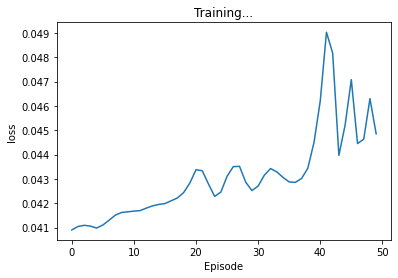

In [24]:
update_times = 50
loss_list = []
for update_time in range(update_times):
    loss = Agent.optimize_model()
    Agent.update_target_net()
    loss_list.append(loss)
    plot_data(loss_list, ylabel="loss")

In [25]:
# DQN_table
obs_dim_shape= env.observation_space
BC_DQN_table = np.zeros((obs_dim_shape + [action_dim]))
print(BC_DQN_table.shape)

# get batch of state
for i in range(obs_dim_shape[0]):
    for j in range(obs_dim_shape[1]):
        state = np.array((i, j)) / env.space_length
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            value = Agent.target_net(state)[0]
            BC_DQN_table[i,j,:] = value.detach().cpu().numpy()

(50, 50, 2)


Text(0, 0.5, 'point_angle')

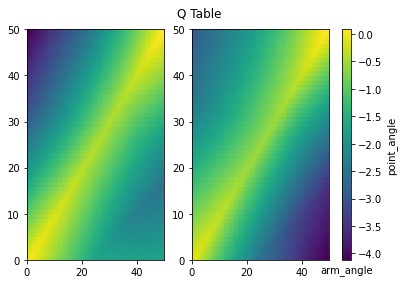

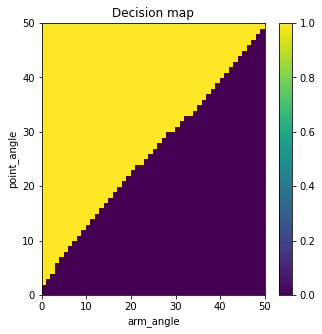

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Q Table')
im1 = ax1.pcolormesh(BC_DQN_table[:, :, 0])
im2 = ax2.pcolormesh(BC_DQN_table[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

plt.xlabel('arm_angle')
plt.ylabel('point_angle')

fig = plt.figure(figsize=(5, 5))
plt.title('Decision map')
max_decision = np.argmax(BC_DQN_table, axis=2)
im = plt.pcolormesh(max_decision)
cbar = fig.colorbar(im)
plt.xlabel('arm_angle')
plt.ylabel('point_angle')